# CRBM class usage


This notebook shows how to use the `crbm` class found in `crbm_tools.py` with some details.

In [173]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import inspect
import json
import pickle

import random
import numpy as np 
import pandas as pd
import numexpr as ne
import sklearn
from sklearn import preprocessing
from matplotlib import pyplot as plt 

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import tstools
from tstools import timeseries  

import Datasets
from Datasets import al_series

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
import CRBM
from CRBM import crbm_tools
from CRBM.crbm_tools import build_slices_from_list_of_arrays

In [175]:
#from path import path
my_path = '../Datasets/al_series/'

files = os.walk(my_path)

X = []

for root, dirs, files in files:
    for f in files:
        x = pd.read_csv(os.path.join(root, f), index_col="Unnamed: 0")
        X.append(x.values)

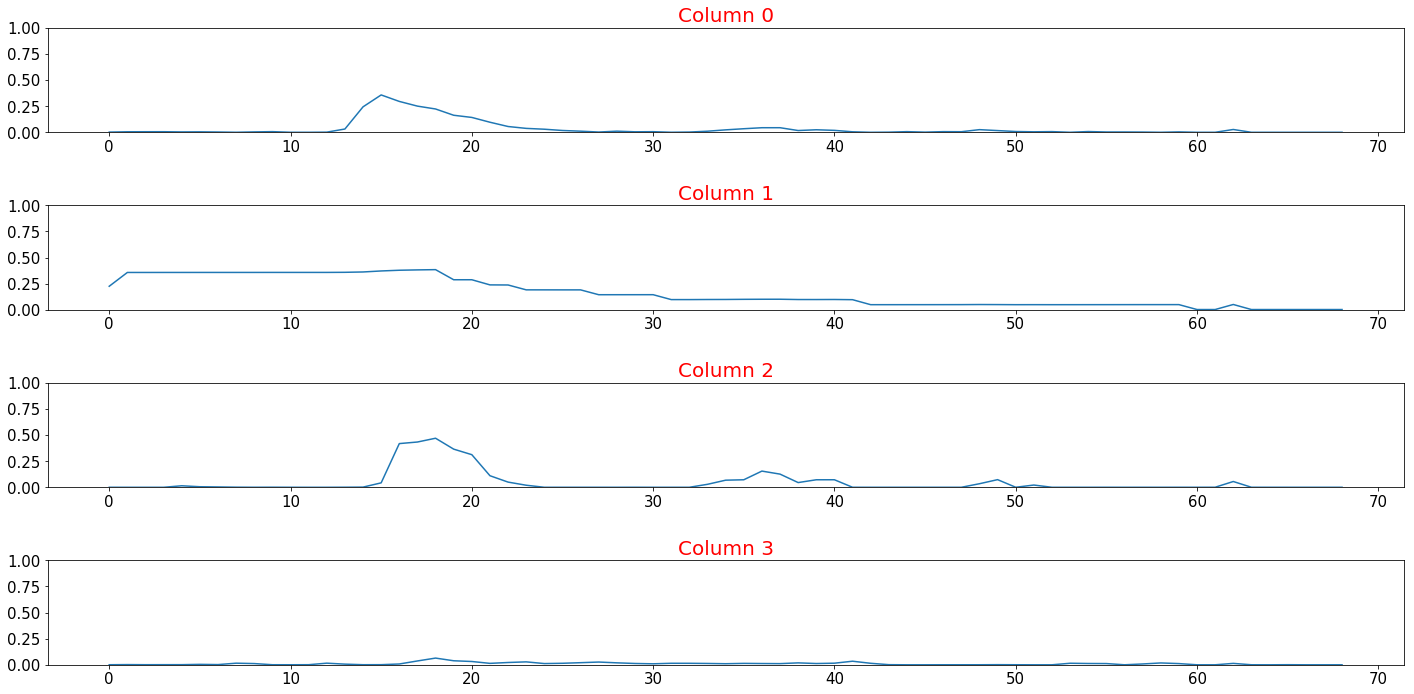

In [176]:
timeseries.plot_timeseries(X[-8])

In [177]:
X_train = X[0:-8]
X_test = X[-8:]
len(X_train), len(X_test),len(X)

(24, 8, 32)

In [178]:
n_feat = X_train[0].shape[1]
n_feat

4


### Generate train slices

We can create, given `n_vis` and `n_his`, a list containing all the slices of those proportions from our timeseries. This will be used for learning.

In [179]:
X_train[0].shape

(637, 4)

In [180]:
X_train[0][0:20].shape

(20, 4)

In [181]:
X_slices = build_slices_from_list_of_arrays(X_train, 20, n_feat)

In [182]:
len(X_slices)

20749

In [183]:
X_slices[0].shape

(21, 4)

### CRBM class

In [299]:
n_his = 20
n_hid = 64

In [300]:
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=n_hid, n_his=n_his, 
                       n_epochs=50,
                       random_state=123, sigma = 0.3);

In [301]:
#crbm.save("./saved_model_test", "crbm_")

In [302]:

saved_crbm = crbm.load("./saved_models/crbm_25_epochs_crbm_class_64hid")

The model ./saved_models/crbm_25_epochs_crbm_class_64hid does not exist!


In [ ]:
crbm.fit(X_slices)

ep 0000 |  min 0.05 sec => rec error: 0.0367
ep 0001 |  min 0.10 sec => rec error: 0.0273
ep 0002 |  min 0.15 sec => rec error: 0.0255


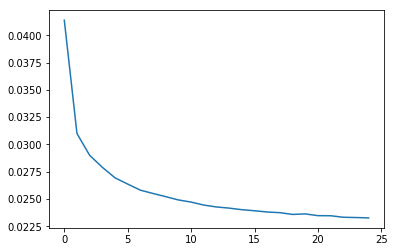

In [214]:
plt.plot(crbm.rec_error_per_epoch)

In [222]:
#crbm.save("./saved_models", "crbm_25_epochs_crbm_class")

## Make predictions with the model

In [83]:
X_tr = X_train[0].T
print("X_tr shape: ", X_tr.shape, "\nslice shape:", crbm_tools.get_slice_at_position_k(X_tr, 25, crbm.n_his).shape)

X_tr shape:  (4, 637) 
slice shape: (4, 21)


## Evaluate the model making predictions given the first values of the trace

### Generating samples without persistent chain

first visible vector at position:  41
(4, 20) 4 (4, 1) (4, 20) (4, 637)
(4, 1) (80, 1) 4 (4, 80) (256, 80) (256, 4)
0.40564730763400003 0.40564730763400003
shapes: (597, 4) (597, 4)
MSE: 0.874992215438644


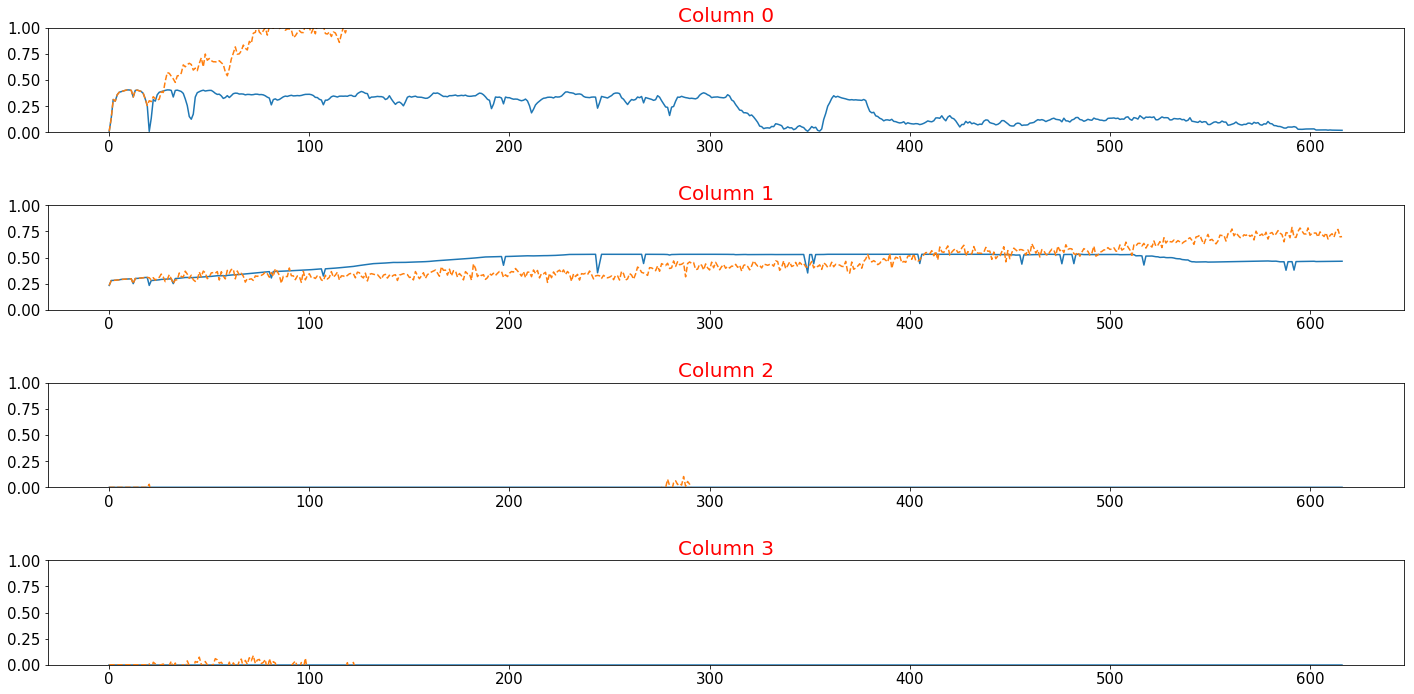

In [260]:
m = 0
X_tr = X_train[m].T

start_pos = 20
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                         # first visible vector
hist_and_v  = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond     = crbm_tools.split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  crbm_tools.history_mat_to_vec(cond)
print("first visible vector at position: ", start_pos + crbm.n_his+1)
print(cond.shape, crbm.n_vis,  v.shape, cond.shape, X_tr.shape)
print(v.shape, cond_as_vec.shape, crbm.n_vis, crbm.A.shape, crbm.B.shape, crbm.W.shape)
print(cond.max(), cond_as_vec.max())

n_samples = X_tr.shape[1] - crbm.n_his
samples = crbm_tools.generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples,
                                         n_gibbs=5)
y_true  = X_tr[:, crbm.n_his:n_samples].T
y_hat   = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]

print("shapes:", y_hat.shape, y_true.shape)
print("MSE:", np.sqrt(np.mean((y_hat - y_true)**2)))

timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)), np.vstack((cond.T, y_hat)))

### Generating samples with a persistent chain

first visible vector at position:  41
(4, 1) (80, 1) 4 (4, 80) (256, 80) (256, 4)
0.40564730763400003 0.40564730763400003
shapes: (597, 4) (597, 4)
MSE: 0.7885811021703097


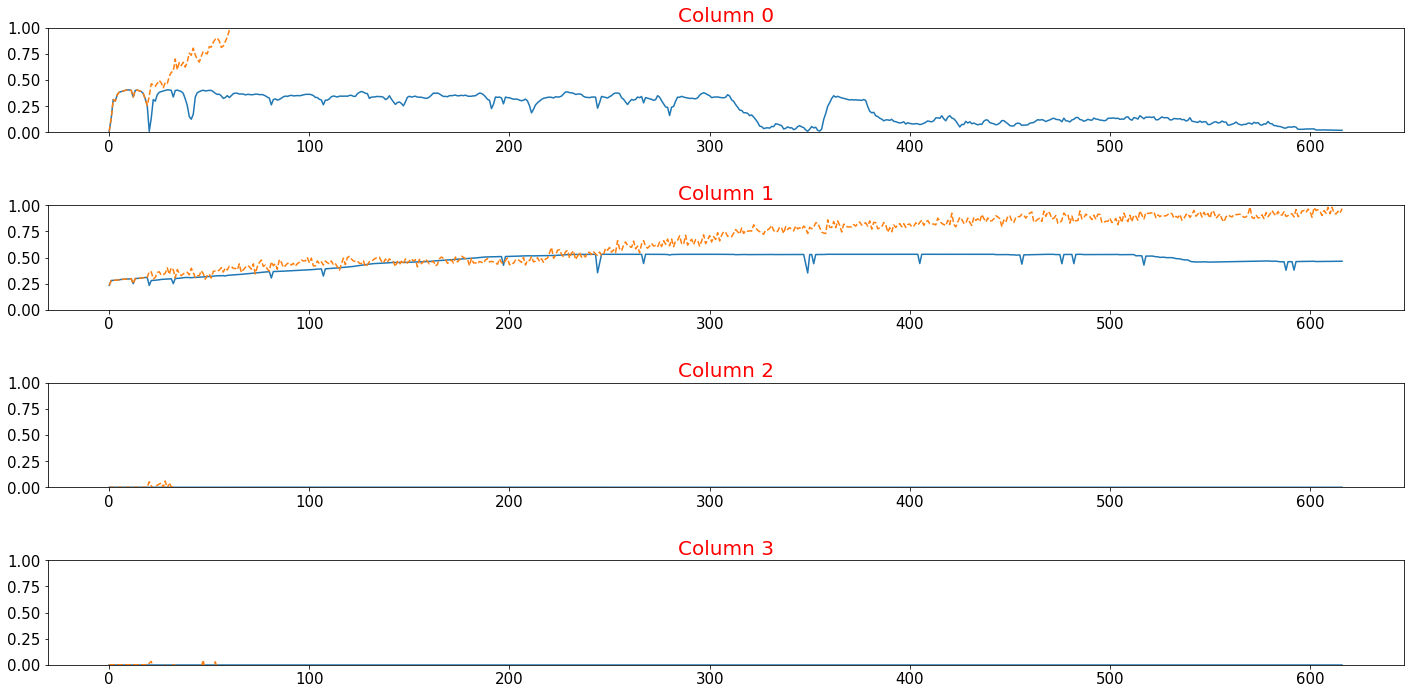

In [263]:
m = 0
X_tr = X_train[m].T

start_pos = 20
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                         # first visible vector
hist_and_v = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond = crbm_tools.split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  crbm_tools.history_mat_to_vec(cond)

print("first visible vector at position: ", start_pos + crbm.n_his+1)
#print(cond.shape, crbm.n_vis,  v.shape, cond.shape, X.shape)
print(v.shape, cond_as_vec.shape, crbm.n_vis, crbm.A.shape, crbm.B.shape, crbm.W.shape)
print(cond.max(), cond_as_vec.max())

n_samples = X_tr.shape[1] - crbm.n_his
samples = crbm.generate_n_samples(v, cond_as_vec, n_samples = n_samples, 
                                  n_gibbs=5, persitent_chain=True)
y_true = X_tr[:, crbm.n_his:n_samples].T
y_hat = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]

print("shapes:", y_hat.shape, y_true.shape)
print("MSE:", np.sqrt(np.mean((y_hat - y_true)**2)))

timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)),np.vstack((cond.T, y_hat)))